# 딥러닝 실습(Fine-Tuning, Batch Normalization, Parameter Initialization)

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"
print("TF version: ",tf.__version__)

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

TF version:  2.4.1
GPU installed:  True


In [3]:
def animal_plot_imgs(np_imgs, labels):
    cols = min(len(np_imgs), 10)
    rows = (len(np_imgs) - 1) // cols + 1
    fig = plt.figure(figsize=(15, 1.5 * rows))
    plt.subplots_adjust(top=1, bottom=0, hspace=0.2, wspace=0.05)
    for i in range(rows):
        for j in range(cols):
            if not i*cols + j < len(np_imgs):
                break
            image = np_imgs[i*cols + j]
            image = image.reshape(64, 64)
            ax = fig.add_subplot(rows, cols, i*cols + j+1)
            ax.imshow(image, cmap=plt.cm.bone)
            ax.grid(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            plt.title(animal_target_names[labels[i*cols + j]])

# Animal face 데이터셋 (from, Kaggle)

### 512 * 512 * 3 = 786,432 features

### 64 * 64 * 1 = 4096 로 축소 & grayscale로 변환



In [4]:
animal_target_names = ['cat', 'dog', 'wild']

In [5]:
import PIL.Image as pilimg
from tqdm.notebook import tqdm

animal_data_set = {}
animal_data_set['data'] = np.empty((0,4096), int)
animal_data_set['target'] = np.array([], np.uint8)
#animal_data_set['target'] = np.empty((0, 3), np.uint8)

path_dir = 'C:/Users/fabia/Desktop/animal_data/train/'
for i in tqdm(range(len(animal_target_names))):
    file_list = os.listdir(path_dir + animal_target_names[i])
    count = 0
    #data = np.empty((0,16384), int)
    data = []
    target = []
    for file_name in tqdm(file_list[:4000]):
        # 이미지 파일 local에서 불러오기
        img_data = pilimg.open(path_dir + animal_target_names[i] + '/' + file_name)
        
        # 이미지 축소 및 grayscale 변환
        #small_gray = img_data.resize((128, 128), pilimg.ANTIALIAS).convert("L")
        small_gray = img_data.resize((64, 64), pilimg.ANTIALIAS).convert("L")
        
        # 이미지 파일 np array로 변환
        np_data = np.array(small_gray)
        
        # (128, 128)형태의 np array를 1차원으로 변환 (4096)
        np_data = np.ravel(np_data, order='C')
        
        # data_set에 이어붙이기. 
        #data = np.append(data, np_data.reshape(1,4096), axis=0)
        data.append(np_data.reshape(4096))
        target_data = []
        for j in range(3):
            if i == j:
                target_data.append(1)
            else:
                target_data.append(0)
        target.append(np.array(target_data).reshape(3))
    animal_data_set['data'] = np.append(animal_data_set['data'], np.asarray(data), axis=0)
    animal_data_set['target'] = np.append(animal_data_set['target'], [np.uint8(i)]*4000)

In [11]:
X, y = animal_data_set['data'], animal_data_set['target']

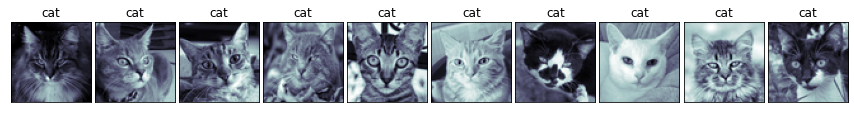

In [133]:
animal_plot_imgs(X[0:4000:400], y[0:4000:400])

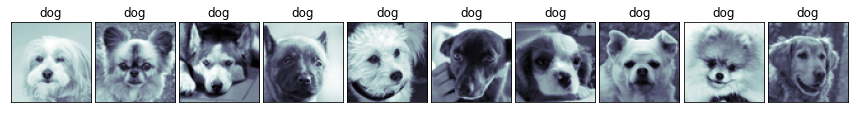

In [135]:
animal_plot_imgs(X[4000:8000:400], y[4000:8000:400])

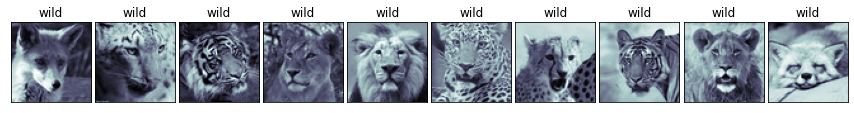

In [136]:
animal_plot_imgs(X[8000:12000:400], y[8000:12000:400])

In [12]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 2000, random_state = 50, shuffle = True)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 2000, random_state = 50, shuffle = True)

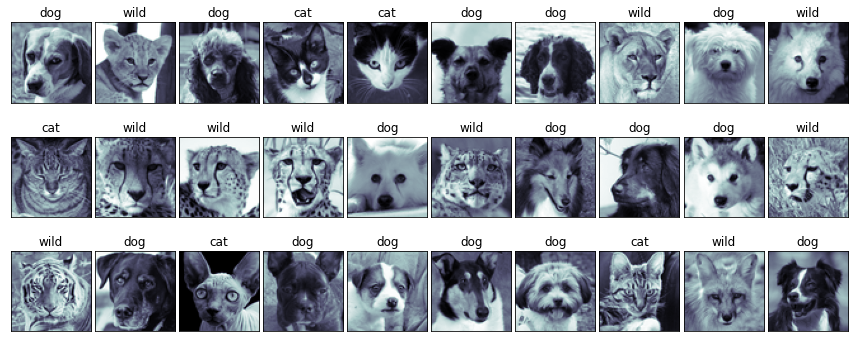

In [128]:
animal_plot_imgs(X_train[:30], y_train[:30])

In [126]:
print(X_train.shape)
print(X_val.shape)
print(X_train.shape)

(8000, 4096)
(2000, 4096)
(8000, 4096)


# Sequential API로 간단한 Classifier 만들기
### Number of hidden layers: 2
### Number of neurons: 300
### activation function: ReLU
### learning rate: 1e-4

In [16]:
import tensorflow as tf
from tensorflow import keras

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=X_train[0].shape))
model.add(keras.layers.Dense(300, activation=keras.activations.relu, input_shape = X_train[0].shape))
model.add(keras.layers.Dense(300, activation=keras.activations.relu))
model.add(keras.layers.Dense(3, activation="softmax"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               1229100   
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 903       
Total params: 1,320,303
Trainable params: 1,320,303
Non-trainable params: 0
_________________________________________________________________


In [20]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-4),
              metrics=["accuracy"])

In [24]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("../my_model.h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights = True)

In [25]:
history = model.fit(X_train, y_train, epochs=500, 
                    validation_data=(X_val, y_val),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/500
250/250 [==============================] - 1s 3ms/step - loss: 0.6804 - accuracy: 0.6990 - val_loss: 0.9488 - val_accuracy: 0.6315
Epoch 2/500
250/250 [==============================] - 1s 3ms/step - loss: 0.6679 - accuracy: 0.7054 - val_loss: 0.9525 - val_accuracy: 0.6345
Epoch 3/500
250/250 [==============================] - 1s 3ms/step - loss: 0.6616 - accuracy: 0.7086 - val_loss: 0.9342 - val_accuracy: 0.6480
Epoch 4/500
250/250 [==============================] - 1s 3ms/step - loss: 0.6414 - accuracy: 0.7240 - val_loss: 0.9304 - val_accuracy: 0.6565
Epoch 5/500
250/250 [==============================] - 1s 3ms/step - loss: 0.6314 - accuracy: 0.7261 - val_loss: 0.9282 - val_accuracy: 0.6640
Epoch 6/500
250/250 [==============================] - 1s 3ms/step - loss: 0.6152 - accuracy: 0.7346 - val_loss: 0.9438 - val_accuracy: 0.6505
Epoch 7/500
250/250 [==============================] - 1s 3ms/step - loss: 0.6011 - accuracy: 0.7384 - val_loss: 0.9094 - val_accuracy: 0.6690

Saving figure keras_learning_curves_plot


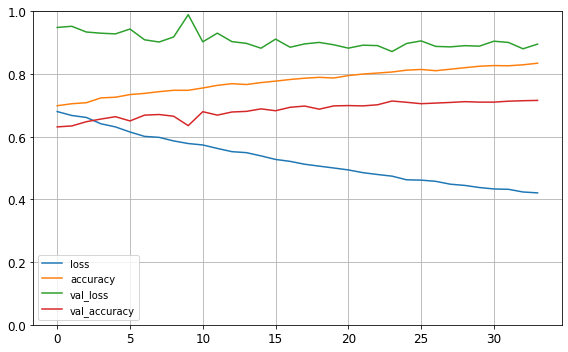

In [26]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

# RandomizedSearch로 hyper parameter 튜닝
### activation function: ReLU

#### hidden layers = 1 ~ 4
#### neurons: 1 ~ 5000
#### learning rate: 0.0001 ~ 0.03



In [27]:
def build_model(input_shape = [4096], n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(3, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [28]:
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)

### 아래 셀의 param_distribs에서
### np.arange() --> range() 로
### reciprocal(a, b) --> map(float, np.logspace(np.log10(a), np.log10(b))) 로
### 변경하였더니 오류가 나지않음

In [30]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

'''
param_distribs = {
    "n_hidden": [0, 1, 2, 3, 4],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}
'''
param_distribs = {
    "n_hidden" : [0, 1, 2, 3, 4],
    "n_neurons" : list(range(1, 5000)),
    "learning_rate" : list(map(float, list(np.logspace(np.log10(0.0001), np.log10(0.03))))),
}

rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=30, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=40, batch_size=32,
                 validation_data = (X_val, y_val),
                 callbacks = [keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/40
167/167 [==============================] - 1s 4ms/step - loss: 33634.8090 - accuracy: 0.3915 - val_loss: 31015.0469 - val_accuracy: 0.4330
Epoch 2/40
167/167 [==============================] - 1s 3ms/step - loss: 18939.8747 - accuracy: 0.4983 - val_loss: 9048.1113 - val_accuracy: 0.5600
Epoch 3/40
167/167 [==============================] - 0s 3ms/step - loss: 12577.5728 - accuracy: 0.5800 - val_loss: 26631.1016 - val_accuracy: 0.4500
Epoch 4/40
167/167 [==============================] - 1s 3ms/step - loss: 13203.1217 - accuracy: 0.5718 - val_loss: 13786.3301 - val_accuracy: 0.5730
Epoch 5/40
167/167 [==============================] - 1s 3ms/step - loss: 15095.4907 - accuracy: 0.5468 - val_loss: 10283.9883 - val_accuracy: 0.6025
Epoch 6/40
167/167 [==============================] - 1s 3ms/step - loss: 11420.2151 - accuracy: 0.6035 - val_loss: 10612.6689 - val_accuracy: 0.5610
Epoch 7/40
167/167 [==============================] - 1s 3ms/step - loss: 9705.6582 - accuracy: 0.627

KeyboardInterrupt: 

In [14]:
rnd_search_cv.best_params_

{'n_neurons': 4527, 'n_hidden': 4, 'learning_rate': 0.00018751655775821934}

In [15]:
rnd_search_cv.best_score_

0.7794270813465118

In [17]:
rnd_search_cv.score(X_test, y_test)

75/75 [==============================] - 0s 4ms/step - loss: 0.7954 - accuracy: 0.7904


0.7904166579246521

## 저번 발표에서 같은 데이터셋으로 고전적인 머신러닝 알고리즘을 튜닝한 결과
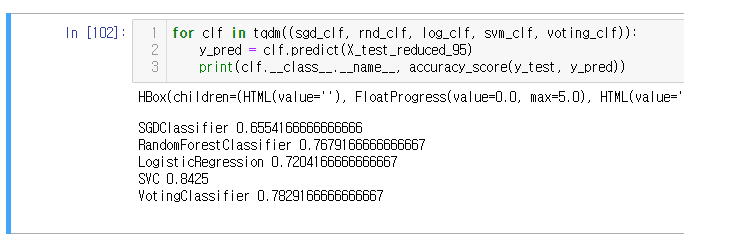
### SVC를 제외한 다른 모델보다는 앞서지만, 아직 아쉽다



# Parameter Initialization, Batch Normalization(배치 정규화) 적용

### activation function: LeakyReLU
### initializer: he normal
### regularizer: L2

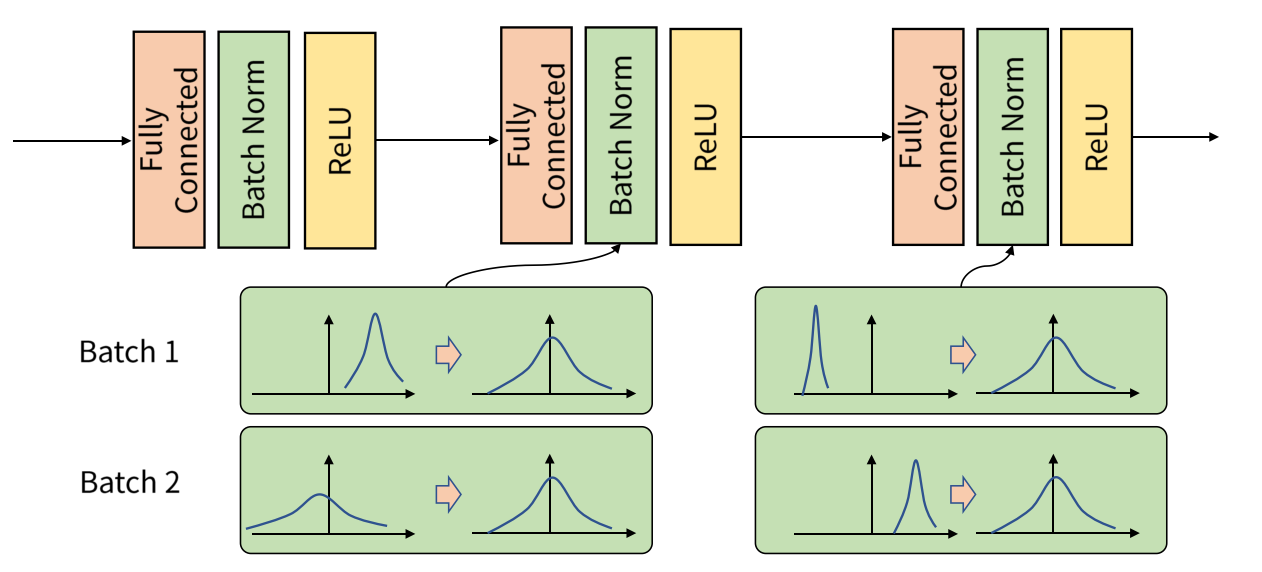

In [ ]:
def build_model(input_shape = [4096], n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.BatchNormalization()) # <--- 배치 정규화
        model.add(keras.layers.Dense(n_neurons, kernel_initializer="he_normal", use_bias=False, # <--- "he_normal"
                                     kernel_regularizer=keras.regularizers.l2(0.01)))
        model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(3, activation="softmax"))
    
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [32]:
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [42]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden" : [1, 2, 3, 4],
    "n_neurons" : list(range(1, 5000)),
    "learning_rate" : list(map(float, list(np.logspace(np.log10(0.0001), np.log10(1))))),
}

rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=20, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=40, batch_size=128,
                 validation_data = (X_val, y_val),
                 callbacks = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)])

Epoch 1/40
42/42 [==============================] - 1s 17ms/step - loss: 38.9874 - accuracy: 0.4290 - val_loss: 39.1411 - val_accuracy: 0.5005
Epoch 2/40
42/42 [==============================] - 0s 9ms/step - loss: 38.3089 - accuracy: 0.6684 - val_loss: 38.2475 - val_accuracy: 0.6485
Epoch 3/40
42/42 [==============================] - 0s 10ms/step - loss: 38.0272 - accuracy: 0.7142 - val_loss: 37.9748 - val_accuracy: 0.6680
Epoch 4/40
42/42 [==============================] - 0s 9ms/step - loss: 37.7500 - accuracy: 0.7657 - val_loss: 37.7274 - val_accuracy: 0.7035
Epoch 5/40
42/42 [==============================] - 0s 9ms/step - loss: 37.5273 - accuracy: 0.7831 - val_loss: 37.4932 - val_accuracy: 0.7310
Epoch 6/40
42/42 [==============================] - 0s 9ms/step - loss: 37.3059 - accuracy: 0.8101 - val_loss: 37.2872 - val_accuracy: 0.7475
Epoch 7/40
42/42 [==============================] - 0s 10ms/step - loss: 37.0893 - accuracy: 0.8223 - val_loss: 37.0867 - val_accuracy: 0.7625
Epo

42/42 [==============================] - 0s 10ms/step - loss: 35.2058 - accuracy: 0.8985 - val_loss: 35.2824 - val_accuracy: 0.7940
Epoch 18/40
42/42 [==============================] - 0s 10ms/step - loss: 35.0154 - accuracy: 0.9070 - val_loss: 35.1071 - val_accuracy: 0.7960
Epoch 19/40
42/42 [==============================] - 0s 10ms/step - loss: 34.8256 - accuracy: 0.9212 - val_loss: 34.9332 - val_accuracy: 0.7955
Epoch 20/40
42/42 [==============================] - 0s 10ms/step - loss: 34.6499 - accuracy: 0.9244 - val_loss: 34.7636 - val_accuracy: 0.8000
Epoch 21/40
42/42 [==============================] - 0s 9ms/step - loss: 34.4759 - accuracy: 0.9236 - val_loss: 34.5900 - val_accuracy: 0.7990
Epoch 22/40
42/42 [==============================] - 0s 10ms/step - loss: 34.2988 - accuracy: 0.9296 - val_loss: 34.4269 - val_accuracy: 0.7965
Epoch 23/40
42/42 [==============================] - 0s 10ms/step - loss: 34.1209 - accuracy: 0.9313 - val_loss: 34.2527 - val_accuracy: 0.8035
Epoch

42/42 [==============================] - 0s 10ms/step - loss: 32.3368 - accuracy: 0.9660 - val_loss: 32.5399 - val_accuracy: 0.8030
Epoch 34/40
42/42 [==============================] - 0s 11ms/step - loss: 32.1713 - accuracy: 0.9692 - val_loss: 32.3799 - val_accuracy: 0.8015
Epoch 35/40
42/42 [==============================] - 0s 10ms/step - loss: 32.0141 - accuracy: 0.9664 - val_loss: 32.2244 - val_accuracy: 0.7985
Epoch 36/40
42/42 [==============================] - 0s 10ms/step - loss: 31.8534 - accuracy: 0.9724 - val_loss: 32.0678 - val_accuracy: 0.8005
Epoch 37/40
42/42 [==============================] - 0s 11ms/step - loss: 31.6911 - accuracy: 0.9713 - val_loss: 31.9111 - val_accuracy: 0.8015
Epoch 38/40
42/42 [==============================] - 0s 11ms/step - loss: 31.5327 - accuracy: 0.9741 - val_loss: 31.7600 - val_accuracy: 0.7980
Epoch 39/40
42/42 [==============================] - 0s 10ms/step - loss: 31.3746 - accuracy: 0.9741 - val_loss: 31.6007 - val_accuracy: 0.8005
Epoc

42/42 [==============================] - 0s 11ms/step - loss: 9.0333 - accuracy: 0.8494 - val_loss: 9.1864 - val_accuracy: 0.7465
Epoch 12/40
42/42 [==============================] - 0s 11ms/step - loss: 8.9817 - accuracy: 0.8573 - val_loss: 9.1417 - val_accuracy: 0.7465
Epoch 13/40
42/42 [==============================] - 0s 11ms/step - loss: 8.9159 - accuracy: 0.8628 - val_loss: 9.0946 - val_accuracy: 0.7515
Epoch 14/40
42/42 [==============================] - 0s 11ms/step - loss: 8.8550 - accuracy: 0.8738 - val_loss: 9.0463 - val_accuracy: 0.7490
Epoch 15/40
42/42 [==============================] - 0s 11ms/step - loss: 8.8026 - accuracy: 0.8794 - val_loss: 9.0002 - val_accuracy: 0.7555
Epoch 16/40
42/42 [==============================] - 0s 11ms/step - loss: 8.7582 - accuracy: 0.8786 - val_loss: 8.9541 - val_accuracy: 0.7590
Epoch 17/40
42/42 [==============================] - 0s 11ms/step - loss: 8.6970 - accuracy: 0.8928 - val_loss: 8.9097 - val_accuracy: 0.7615
Epoch 18/40
42/42 

42/42 [==============================] - 0s 11ms/step - loss: 7.8244 - accuracy: 0.9691 - val_loss: 8.2177 - val_accuracy: 0.7765
Epoch 35/40
42/42 [==============================] - 1s 12ms/step - loss: 7.7888 - accuracy: 0.9643 - val_loss: 8.1871 - val_accuracy: 0.7720
Epoch 36/40
42/42 [==============================] - 0s 11ms/step - loss: 7.7480 - accuracy: 0.9664 - val_loss: 8.1517 - val_accuracy: 0.7700
Epoch 37/40
42/42 [==============================] - 0s 11ms/step - loss: 7.7019 - accuracy: 0.9717 - val_loss: 8.1210 - val_accuracy: 0.7710
Epoch 38/40
42/42 [==============================] - 0s 11ms/step - loss: 7.6533 - accuracy: 0.9776 - val_loss: 8.0795 - val_accuracy: 0.7740
Epoch 39/40
42/42 [==============================] - 0s 11ms/step - loss: 7.6206 - accuracy: 0.9702 - val_loss: 8.0425 - val_accuracy: 0.7745
Epoch 40/40
84/84 [==============================] - 0s 4ms/step - loss: 8.0307 - accuracy: 0.7757
Epoch 1/40
42/42 [==============================] - 1s 23ms/s

42/42 [==============================] - 1s 20ms/step - loss: 1.9696 - accuracy: 0.8084 - val_loss: 1.7200 - val_accuracy: 0.7655
Epoch 16/40
42/42 [==============================] - 1s 19ms/step - loss: 1.5541 - accuracy: 0.8157 - val_loss: 1.4068 - val_accuracy: 0.8035
Epoch 17/40
42/42 [==============================] - 1s 19ms/step - loss: 1.3131 - accuracy: 0.8233 - val_loss: 1.6563 - val_accuracy: 0.6750
Epoch 18/40
42/42 [==============================] - 1s 19ms/step - loss: 1.1629 - accuracy: 0.8202 - val_loss: 1.4328 - val_accuracy: 0.6830
Epoch 19/40
42/42 [==============================] - 1s 19ms/step - loss: 0.9997 - accuracy: 0.8173 - val_loss: 1.0132 - val_accuracy: 0.7920
Epoch 20/40
42/42 [==============================] - 1s 19ms/step - loss: 0.7994 - accuracy: 0.8711 - val_loss: 1.1629 - val_accuracy: 0.7365
Epoch 21/40
42/42 [==============================] - 1s 19ms/step - loss: 0.9426 - accuracy: 0.7971 - val_loss: 0.9027 - val_accuracy: 0.7865
Epoch 22/40
42/42 

42/42 [==============================] - 1s 35ms/step - loss: 226.2824 - accuracy: 0.5540 - val_loss: 226.3895 - val_accuracy: 0.5180
Epoch 4/40
42/42 [==============================] - 1s 35ms/step - loss: 226.1087 - accuracy: 0.6108 - val_loss: 226.1311 - val_accuracy: 0.5685
Epoch 5/40
42/42 [==============================] - 1s 34ms/step - loss: 225.9483 - accuracy: 0.6369 - val_loss: 225.9440 - val_accuracy: 0.6055
Epoch 6/40
42/42 [==============================] - 1s 34ms/step - loss: 225.8152 - accuracy: 0.6470 - val_loss: 225.7943 - val_accuracy: 0.6250
Epoch 7/40
42/42 [==============================] - 1s 35ms/step - loss: 225.6702 - accuracy: 0.6786 - val_loss: 225.6636 - val_accuracy: 0.6465
Epoch 8/40
42/42 [==============================] - 1s 35ms/step - loss: 225.5531 - accuracy: 0.6919 - val_loss: 225.5419 - val_accuracy: 0.6660
Epoch 9/40
42/42 [==============================] - 2s 36ms/step - loss: 225.4394 - accuracy: 0.7021 - val_loss: 225.4247 - val_accuracy: 0.6

Epoch 19/40
42/42 [==============================] - 2s 37ms/step - loss: 224.2876 - accuracy: 0.7995 - val_loss: 224.3590 - val_accuracy: 0.7360
Epoch 20/40
42/42 [==============================] - 2s 36ms/step - loss: 224.1866 - accuracy: 0.7999 - val_loss: 224.2581 - val_accuracy: 0.7370
Epoch 21/40
42/42 [==============================] - 2s 37ms/step - loss: 224.0903 - accuracy: 0.8039 - val_loss: 224.1565 - val_accuracy: 0.7395
Epoch 22/40
42/42 [==============================] - 2s 37ms/step - loss: 223.9835 - accuracy: 0.8114 - val_loss: 224.0561 - val_accuracy: 0.7405
Epoch 23/40
42/42 [==============================] - 2s 37ms/step - loss: 223.8611 - accuracy: 0.8195 - val_loss: 223.9557 - val_accuracy: 0.7435
Epoch 24/40
42/42 [==============================] - 2s 37ms/step - loss: 223.7735 - accuracy: 0.8195 - val_loss: 223.8553 - val_accuracy: 0.7465
Epoch 25/40
42/42 [==============================] - 2s 37ms/step - loss: 223.6668 - accuracy: 0.8266 - val_loss: 223.7569 -

42/42 [==============================] - 2s 36ms/step - loss: 222.9130 - accuracy: 0.8578 - val_loss: 223.0351 - val_accuracy: 0.7565
Epoch 35/40
42/42 [==============================] - 2s 39ms/step - loss: 222.8150 - accuracy: 0.8603 - val_loss: 222.9375 - val_accuracy: 0.7570
Epoch 36/40
42/42 [==============================] - 2s 36ms/step - loss: 222.7162 - accuracy: 0.8608 - val_loss: 222.8399 - val_accuracy: 0.7565
Epoch 37/40
42/42 [==============================] - 1s 35ms/step - loss: 222.6206 - accuracy: 0.8611 - val_loss: 222.7418 - val_accuracy: 0.7590
Epoch 38/40
42/42 [==============================] - 1s 35ms/step - loss: 222.5096 - accuracy: 0.8740 - val_loss: 222.6444 - val_accuracy: 0.7600
Epoch 39/40
42/42 [==============================] - 1s 35ms/step - loss: 222.4135 - accuracy: 0.8685 - val_loss: 222.5467 - val_accuracy: 0.7600
Epoch 40/40
84/84 [==============================] - 1s 7ms/step - loss: 222.4532 - accuracy: 0.7659
Epoch 1/40
42/42 [=================

42/42 [==============================] - 1s 19ms/step - loss: 121.6621 - accuracy: 0.8346 - val_loss: 121.5945 - val_accuracy: 0.7640
Epoch 10/40
42/42 [==============================] - 1s 19ms/step - loss: 121.3585 - accuracy: 0.8486 - val_loss: 121.3023 - val_accuracy: 0.7715
Epoch 11/40
42/42 [==============================] - 1s 19ms/step - loss: 121.0554 - accuracy: 0.8564 - val_loss: 121.0135 - val_accuracy: 0.7790
Epoch 12/40
42/42 [==============================] - 1s 19ms/step - loss: 120.7584 - accuracy: 0.8686 - val_loss: 120.7280 - val_accuracy: 0.7800
Epoch 13/40
42/42 [==============================] - 1s 19ms/step - loss: 120.4517 - accuracy: 0.8827 - val_loss: 120.4434 - val_accuracy: 0.7820
Epoch 14/40
42/42 [==============================] - 1s 19ms/step - loss: 120.1619 - accuracy: 0.8838 - val_loss: 120.1626 - val_accuracy: 0.7800
Epoch 15/40
42/42 [==============================] - 1s 19ms/step - loss: 119.8659 - accuracy: 0.8932 - val_loss: 119.8771 - val_accurac

42/42 [==============================] - 1s 20ms/step - loss: 117.2228 - accuracy: 0.9398 - val_loss: 117.3206 - val_accuracy: 0.7915
Epoch 25/40
42/42 [==============================] - 1s 19ms/step - loss: 116.9501 - accuracy: 0.9429 - val_loss: 117.0463 - val_accuracy: 0.7945
Epoch 26/40
42/42 [==============================] - 1s 20ms/step - loss: 116.6764 - accuracy: 0.9400 - val_loss: 116.7747 - val_accuracy: 0.7960
Epoch 27/40
42/42 [==============================] - 1s 20ms/step - loss: 116.3914 - accuracy: 0.9492 - val_loss: 116.5036 - val_accuracy: 0.7940
Epoch 28/40
42/42 [==============================] - 1s 20ms/step - loss: 116.1097 - accuracy: 0.9575 - val_loss: 116.2292 - val_accuracy: 0.7960
Epoch 29/40
42/42 [==============================] - 1s 20ms/step - loss: 115.8363 - accuracy: 0.9572 - val_loss: 115.9585 - val_accuracy: 0.7985
Epoch 30/40
42/42 [==============================] - 1s 20ms/step - loss: 115.5566 - accuracy: 0.9591 - val_loss: 115.6884 - val_accurac

42/42 [==============================] - 1s 26ms/step - loss: 147.7452 - accuracy: 0.9073 - val_loss: 147.8951 - val_accuracy: 0.7890
Epoch 40/40
84/84 [==============================] - 1s 5ms/step - loss: 147.7866 - accuracy: 0.7750
Epoch 1/40
42/42 [==============================] - 2s 29ms/step - loss: 154.0139 - accuracy: 0.3921 - val_loss: 154.9322 - val_accuracy: 0.3910
Epoch 2/40
42/42 [==============================] - 1s 26ms/step - loss: 153.4870 - accuracy: 0.5674 - val_loss: 153.8328 - val_accuracy: 0.4900
Epoch 3/40
42/42 [==============================] - 1s 26ms/step - loss: 153.2345 - accuracy: 0.6225 - val_loss: 153.3466 - val_accuracy: 0.5655
Epoch 4/40
42/42 [==============================] - 1s 26ms/step - loss: 153.0203 - accuracy: 0.6646 - val_loss: 153.0197 - val_accuracy: 0.6155
Epoch 5/40
42/42 [==============================] - 1s 26ms/step - loss: 152.8191 - accuracy: 0.7010 - val_loss: 152.7947 - val_accuracy: 0.6530
Epoch 6/40
42/42 [======================

42/42 [==============================] - 1s 27ms/step - loss: 151.3522 - accuracy: 0.8091 - val_loss: 151.3821 - val_accuracy: 0.7525
Epoch 15/40
42/42 [==============================] - 1s 26ms/step - loss: 151.2163 - accuracy: 0.8080 - val_loss: 151.2363 - val_accuracy: 0.7570
Epoch 16/40
42/42 [==============================] - 1s 26ms/step - loss: 151.0474 - accuracy: 0.8204 - val_loss: 151.0937 - val_accuracy: 0.7540
Epoch 17/40
42/42 [==============================] - 1s 27ms/step - loss: 150.9145 - accuracy: 0.8162 - val_loss: 150.9508 - val_accuracy: 0.7595
Epoch 18/40
42/42 [==============================] - 1s 26ms/step - loss: 150.7622 - accuracy: 0.8308 - val_loss: 150.8088 - val_accuracy: 0.7600
Epoch 19/40
42/42 [==============================] - 1s 26ms/step - loss: 150.6028 - accuracy: 0.8420 - val_loss: 150.6671 - val_accuracy: 0.7585
Epoch 20/40
42/42 [==============================] - 1s 26ms/step - loss: 150.4610 - accuracy: 0.8316 - val_loss: 150.5259 - val_accurac

42/42 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.3324 - val_loss: nan - val_accuracy: 0.3395
Epoch 9/40
42/42 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.3393 - val_loss: nan - val_accuracy: 0.3395
Epoch 10/40
42/42 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.3318 - val_loss: nan - val_accuracy: 0.3395
Epoch 11/40
84/84 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.3327
Epoch 1/40
42/42 [==============================] - 3s 45ms/step - loss: 278.2905 - accuracy: 0.5291 - val_loss: 268.6798 - val_accuracy: 0.3360
Epoch 2/40
42/42 [==============================] - 2s 41ms/step - loss: 249.2478 - accuracy: 0.7661 - val_loss: 231.3236 - val_accuracy: 0.6865
Epoch 3/40
42/42 [==============================] - 2s 41ms/step - loss: 224.9308 - accuracy: 0.8761 - val_loss: 209.0295 - val_accuracy: 0.7400
Epoch 4/40
42/42 [==============================] - 2s 41ms/step - loss: 2

42/42 [==============================] - 2s 41ms/step - loss: 111.4136 - accuracy: 0.9978 - val_loss: 103.8231 - val_accuracy: 0.8050
Epoch 11/40
42/42 [==============================] - 2s 41ms/step - loss: 100.7848 - accuracy: 0.9982 - val_loss: 94.0153 - val_accuracy: 0.8055
Epoch 12/40
42/42 [==============================] - 2s 40ms/step - loss: 91.1748 - accuracy: 0.9983 - val_loss: 85.0662 - val_accuracy: 0.7985
Epoch 13/40
42/42 [==============================] - 2s 40ms/step - loss: 82.4743 - accuracy: 1.0000 - val_loss: 77.0234 - val_accuracy: 0.8060
Epoch 14/40
42/42 [==============================] - 2s 41ms/step - loss: 74.6087 - accuracy: 1.0000 - val_loss: 69.7513 - val_accuracy: 0.7965
Epoch 15/40
42/42 [==============================] - 2s 41ms/step - loss: 67.4946 - accuracy: 0.9998 - val_loss: 63.1239 - val_accuracy: 0.8070
Epoch 16/40
42/42 [==============================] - 2s 40ms/step - loss: 61.0567 - accuracy: 1.0000 - val_loss: 57.1922 - val_accuracy: 0.8020
E

42/42 [==============================] - 1s 31ms/step - loss: 181.8458 - accuracy: 0.8238 - val_loss: 181.6936 - val_accuracy: 0.7605
Epoch 9/40
42/42 [==============================] - 1s 31ms/step - loss: 181.4744 - accuracy: 0.8305 - val_loss: 181.3303 - val_accuracy: 0.7715
Epoch 10/40
42/42 [==============================] - 1s 31ms/step - loss: 181.1134 - accuracy: 0.8343 - val_loss: 180.9720 - val_accuracy: 0.7730
Epoch 11/40
42/42 [==============================] - 1s 31ms/step - loss: 180.7400 - accuracy: 0.8502 - val_loss: 180.6180 - val_accuracy: 0.7780
Epoch 12/40
42/42 [==============================] - 1s 31ms/step - loss: 180.3790 - accuracy: 0.8588 - val_loss: 180.2652 - val_accuracy: 0.7770
Epoch 13/40
42/42 [==============================] - 1s 31ms/step - loss: 180.0080 - accuracy: 0.8649 - val_loss: 179.9159 - val_accuracy: 0.7745
Epoch 14/40
42/42 [==============================] - 1s 31ms/step - loss: 179.6491 - accuracy: 0.8767 - val_loss: 179.5690 - val_accuracy

42/42 [==============================] - 1s 32ms/step - loss: 176.4627 - accuracy: 0.9023 - val_loss: 176.4264 - val_accuracy: 0.7830
Epoch 24/40
42/42 [==============================] - 1s 32ms/step - loss: 176.1032 - accuracy: 0.9057 - val_loss: 176.0830 - val_accuracy: 0.7875
Epoch 25/40
42/42 [==============================] - 1s 31ms/step - loss: 175.7651 - accuracy: 0.9126 - val_loss: 175.7438 - val_accuracy: 0.7890
Epoch 26/40
42/42 [==============================] - 1s 31ms/step - loss: 175.4145 - accuracy: 0.9139 - val_loss: 175.4044 - val_accuracy: 0.7900
Epoch 27/40
42/42 [==============================] - 1s 31ms/step - loss: 175.0755 - accuracy: 0.9177 - val_loss: 175.0722 - val_accuracy: 0.7860
Epoch 28/40
42/42 [==============================] - 1s 31ms/step - loss: 174.7299 - accuracy: 0.9160 - val_loss: 174.7271 - val_accuracy: 0.7910
Epoch 29/40
42/42 [==============================] - 1s 31ms/step - loss: 174.3823 - accuracy: 0.9299 - val_loss: 174.3886 - val_accurac

Epoch 40/40
84/84 [==============================] - 0s 3ms/step - loss: 1.8171 - accuracy: 0.7810
Epoch 1/40
42/42 [==============================] - 1s 8ms/step - loss: 2.7158 - accuracy: 0.4689 - val_loss: 2.7405 - val_accuracy: 0.5555
Epoch 2/40
42/42 [==============================] - 0s 5ms/step - loss: 2.3750 - accuracy: 0.6373 - val_loss: 2.4072 - val_accuracy: 0.6385
Epoch 3/40
42/42 [==============================] - 0s 5ms/step - loss: 2.2852 - accuracy: 0.6780 - val_loss: 2.2947 - val_accuracy: 0.6785
Epoch 4/40
42/42 [==============================] - 0s 6ms/step - loss: 2.1986 - accuracy: 0.7318 - val_loss: 2.2405 - val_accuracy: 0.7085
Epoch 5/40
42/42 [==============================] - 0s 5ms/step - loss: 2.1522 - accuracy: 0.7515 - val_loss: 2.1991 - val_accuracy: 0.7240
Epoch 6/40
42/42 [==============================] - 0s 6ms/step - loss: 2.1221 - accuracy: 0.7636 - val_loss: 2.1765 - val_accuracy: 0.7240
Epoch 7/40
42/42 [==============================] - 0s 6ms/st

Epoch 17/40
42/42 [==============================] - 0s 6ms/step - loss: 1.9044 - accuracy: 0.8250 - val_loss: 1.9960 - val_accuracy: 0.7745
Epoch 18/40
42/42 [==============================] - 0s 6ms/step - loss: 1.8751 - accuracy: 0.8341 - val_loss: 1.9885 - val_accuracy: 0.7735
Epoch 19/40
42/42 [==============================] - 0s 5ms/step - loss: 1.8518 - accuracy: 0.8406 - val_loss: 1.9770 - val_accuracy: 0.7750
Epoch 20/40
42/42 [==============================] - 0s 5ms/step - loss: 1.8481 - accuracy: 0.8361 - val_loss: 1.9646 - val_accuracy: 0.7780
Epoch 21/40
42/42 [==============================] - 0s 5ms/step - loss: 1.8298 - accuracy: 0.8525 - val_loss: 1.9592 - val_accuracy: 0.7710
Epoch 22/40
42/42 [==============================] - 0s 5ms/step - loss: 1.8068 - accuracy: 0.8546 - val_loss: 1.9443 - val_accuracy: 0.7765
Epoch 23/40
42/42 [==============================] - 0s 5ms/step - loss: 1.7964 - accuracy: 0.8531 - val_loss: 1.9342 - val_accuracy: 0.7810
Epoch 24/40
4

42/42 [==============================] - 3s 53ms/step - loss: 249.0270 - accuracy: 0.5286 - val_loss: 243.9210 - val_accuracy: 0.5185
Epoch 2/40
42/42 [==============================] - 2s 45ms/step - loss: 222.7879 - accuracy: 0.7602 - val_loss: 207.4864 - val_accuracy: 0.6240
Epoch 3/40
42/42 [==============================] - 2s 47ms/step - loss: 200.9701 - accuracy: 0.9006 - val_loss: 188.1400 - val_accuracy: 0.6125
Epoch 4/40
42/42 [==============================] - 2s 42ms/step - loss: 181.8594 - accuracy: 0.9144 - val_loss: 169.4443 - val_accuracy: 0.6925
Epoch 5/40
42/42 [==============================] - 2s 45ms/step - loss: 164.3406 - accuracy: 0.9738 - val_loss: 152.9636 - val_accuracy: 0.7860
Epoch 6/40
42/42 [==============================] - 2s 45ms/step - loss: 148.6534 - accuracy: 0.9885 - val_loss: 138.3212 - val_accuracy: 0.8100
Epoch 7/40
42/42 [==============================] - 2s 45ms/step - loss: 134.4494 - accuracy: 0.9994 - val_loss: 125.1498 - val_accuracy: 0.8

42/42 [==============================] - 2s 58ms/step - loss: 316.5831 - accuracy: 0.9986 - val_loss: 311.8134 - val_accuracy: 0.8035
Epoch 8/40
42/42 [==============================] - 2s 58ms/step - loss: 309.6040 - accuracy: 0.9998 - val_loss: 304.9434 - val_accuracy: 0.8135
Epoch 9/40
42/42 [==============================] - 2s 58ms/step - loss: 302.7832 - accuracy: 0.9997 - val_loss: 298.2458 - val_accuracy: 0.8140
Epoch 10/40
42/42 [==============================] - 2s 58ms/step - loss: 296.1121 - accuracy: 0.9999 - val_loss: 291.6766 - val_accuracy: 0.8180
Epoch 11/40
42/42 [==============================] - 2s 58ms/step - loss: 289.5867 - accuracy: 0.9999 - val_loss: 285.2737 - val_accuracy: 0.8145
Epoch 12/40
42/42 [==============================] - 2s 57ms/step - loss: 283.2070 - accuracy: 1.0000 - val_loss: 278.9950 - val_accuracy: 0.8155
Epoch 13/40
42/42 [==============================] - 2s 58ms/step - loss: 276.9670 - accuracy: 1.0000 - val_loss: 272.8628 - val_accuracy:

42/42 [==============================] - 1s 26ms/step - loss: nan - accuracy: 0.3343 - val_loss: nan - val_accuracy: 0.3395
Epoch 4/40
42/42 [==============================] - 1s 26ms/step - loss: nan - accuracy: 0.3318 - val_loss: nan - val_accuracy: 0.3395
Epoch 5/40
42/42 [==============================] - 1s 26ms/step - loss: nan - accuracy: 0.3279 - val_loss: nan - val_accuracy: 0.3395
Epoch 6/40
42/42 [==============================] - 1s 26ms/step - loss: nan - accuracy: 0.3378 - val_loss: nan - val_accuracy: 0.3395
Epoch 7/40
42/42 [==============================] - 1s 25ms/step - loss: nan - accuracy: 0.3331 - val_loss: nan - val_accuracy: 0.3395
Epoch 8/40
42/42 [==============================] - 1s 26ms/step - loss: nan - accuracy: 0.3302 - val_loss: nan - val_accuracy: 0.3395
Epoch 9/40
42/42 [==============================] - 1s 27ms/step - loss: nan - accuracy: 0.3358 - val_loss: nan - val_accuracy: 0.3395
Epoch 10/40
42/42 [==============================] - 1s 26ms/step 

42/42 [==============================] - 1s 13ms/step - loss: 36.2906 - accuracy: 0.9991 - val_loss: 36.3834 - val_accuracy: 0.7130
Epoch 17/40
42/42 [==============================] - 1s 13ms/step - loss: 35.0533 - accuracy: 0.9581 - val_loss: 34.6393 - val_accuracy: 0.7640
Epoch 18/40
42/42 [==============================] - 1s 13ms/step - loss: 33.6326 - accuracy: 0.9754 - val_loss: 33.1092 - val_accuracy: 0.8180
Epoch 19/40
42/42 [==============================] - 1s 13ms/step - loss: 32.2797 - accuracy: 0.9994 - val_loss: 31.8263 - val_accuracy: 0.8245
Epoch 20/40
42/42 [==============================] - 1s 13ms/step - loss: 31.0391 - accuracy: 1.0000 - val_loss: 30.6274 - val_accuracy: 0.8215
Epoch 21/40
42/42 [==============================] - 1s 12ms/step - loss: 29.8473 - accuracy: 0.9999 - val_loss: 29.4721 - val_accuracy: 0.8275
Epoch 22/40
42/42 [==============================] - 1s 13ms/step - loss: 28.7014 - accuracy: 1.0000 - val_loss: 28.4977 - val_accuracy: 0.7850
Epoc

84/84 [==============================] - 0s 4ms/step - loss: 14.2903 - accuracy: 0.8256
Epoch 1/40
42/42 [==============================] - 2s 29ms/step - loss: 156.0997 - accuracy: 0.5687 - val_loss: 153.4415 - val_accuracy: 0.6545
Epoch 2/40
42/42 [==============================] - 1s 26ms/step - loss: 151.9779 - accuracy: 0.7869 - val_loss: 149.7941 - val_accuracy: 0.7090
Epoch 3/40
42/42 [==============================] - 1s 26ms/step - loss: 148.5019 - accuracy: 0.8427 - val_loss: 146.3352 - val_accuracy: 0.7360
Epoch 4/40
42/42 [==============================] - 1s 26ms/step - loss: 145.1275 - accuracy: 0.8916 - val_loss: 143.0061 - val_accuracy: 0.7780
Epoch 5/40
42/42 [==============================] - 1s 27ms/step - loss: 141.8671 - accuracy: 0.9305 - val_loss: 139.8898 - val_accuracy: 0.7805
Epoch 6/40
42/42 [==============================] - 1s 26ms/step - loss: 138.7213 - accuracy: 0.9416 - val_loss: 136.7447 - val_accuracy: 0.8020
Epoch 7/40
42/42 [========================

42/42 [==============================] - 1s 29ms/step - loss: 88.7892 - accuracy: 1.0000 - val_loss: 87.8014 - val_accuracy: 0.8185
Epoch 27/40
42/42 [==============================] - 1s 28ms/step - loss: 86.8361 - accuracy: 1.0000 - val_loss: 85.8656 - val_accuracy: 0.8285
Epoch 28/40
42/42 [==============================] - 1s 28ms/step - loss: 84.9234 - accuracy: 1.0000 - val_loss: 83.9865 - val_accuracy: 0.8250
Epoch 29/40
42/42 [==============================] - 1s 28ms/step - loss: 83.0513 - accuracy: 1.0000 - val_loss: 82.1469 - val_accuracy: 0.8245
Epoch 30/40
42/42 [==============================] - 1s 28ms/step - loss: 81.2224 - accuracy: 1.0000 - val_loss: 80.3518 - val_accuracy: 0.8245
Epoch 31/40
42/42 [==============================] - 1s 28ms/step - loss: 79.4335 - accuracy: 1.0000 - val_loss: 78.5930 - val_accuracy: 0.8290
Epoch 32/40
42/42 [==============================] - 1s 28ms/step - loss: 77.6867 - accuracy: 1.0000 - val_loss: 76.8761 - val_accuracy: 0.8255
Epoc

42/42 [==============================] - 1s 14ms/step - loss: 42.2368 - accuracy: 0.5445 - val_loss: 42.4351 - val_accuracy: 0.5275
Epoch 2/40
42/42 [==============================] - 0s 11ms/step - loss: 40.7809 - accuracy: 0.8042 - val_loss: 40.4620 - val_accuracy: 0.6590
Epoch 3/40
42/42 [==============================] - 0s 11ms/step - loss: 39.7730 - accuracy: 0.8595 - val_loss: 39.4080 - val_accuracy: 0.7245
Epoch 4/40
42/42 [==============================] - 0s 11ms/step - loss: 38.8263 - accuracy: 0.9052 - val_loss: 38.4961 - val_accuracy: 0.7470
Epoch 5/40
42/42 [==============================] - 0s 11ms/step - loss: 37.9241 - accuracy: 0.9300 - val_loss: 37.6660 - val_accuracy: 0.7675
Epoch 6/40
42/42 [==============================] - 0s 11ms/step - loss: 37.0687 - accuracy: 0.9337 - val_loss: 36.7851 - val_accuracy: 0.7795
Epoch 7/40
42/42 [==============================] - 0s 11ms/step - loss: 36.2181 - accuracy: 0.9569 - val_loss: 35.9769 - val_accuracy: 0.7905
Epoch 8/40

42/42 [==============================] - 0s 11ms/step - loss: 28.9188 - accuracy: 0.9991 - val_loss: 28.9367 - val_accuracy: 0.8130
Epoch 18/40
42/42 [==============================] - 0s 11ms/step - loss: 28.2809 - accuracy: 0.9995 - val_loss: 28.3213 - val_accuracy: 0.8080
Epoch 19/40
42/42 [==============================] - 0s 11ms/step - loss: 27.6552 - accuracy: 0.9997 - val_loss: 27.6846 - val_accuracy: 0.8150
Epoch 20/40
42/42 [==============================] - 0s 11ms/step - loss: 27.0454 - accuracy: 1.0000 - val_loss: 27.0917 - val_accuracy: 0.8160
Epoch 21/40
42/42 [==============================] - 0s 11ms/step - loss: 26.4500 - accuracy: 0.9999 - val_loss: 26.5085 - val_accuracy: 0.8125
Epoch 22/40
42/42 [==============================] - 0s 10ms/step - loss: 25.8666 - accuracy: 1.0000 - val_loss: 25.9836 - val_accuracy: 0.8060
Epoch 23/40
42/42 [==============================] - 0s 10ms/step - loss: 25.2971 - accuracy: 0.9998 - val_loss: 25.3974 - val_accuracy: 0.8110
Epoc

42/42 [==============================] - 0s 11ms/step - loss: 19.3338 - accuracy: 1.0000 - val_loss: 19.5479 - val_accuracy: 0.8080
Epoch 36/40
42/42 [==============================] - 0s 11ms/step - loss: 18.9083 - accuracy: 1.0000 - val_loss: 19.1288 - val_accuracy: 0.8105
Epoch 37/40
42/42 [==============================] - 0s 12ms/step - loss: 18.4925 - accuracy: 1.0000 - val_loss: 18.7200 - val_accuracy: 0.8125
Epoch 38/40
42/42 [==============================] - 1s 12ms/step - loss: 18.0828 - accuracy: 1.0000 - val_loss: 18.3322 - val_accuracy: 0.8070
Epoch 39/40
42/42 [==============================] - 0s 11ms/step - loss: 17.6866 - accuracy: 1.0000 - val_loss: 17.9271 - val_accuracy: 0.8150
Epoch 40/40
84/84 [==============================] - 0s 4ms/step - loss: 17.5602 - accuracy: 0.8143
Epoch 1/40
42/42 [==============================] - 2s 21ms/step - loss: nan - accuracy: 0.3381 - val_loss: nan - val_accuracy: 0.3395
Epoch 2/40
42/42 [==============================] - 1s 18

42/42 [==============================] - 1s 25ms/step - loss: 119.0243 - accuracy: 0.9575 - val_loss: 118.8381 - val_accuracy: 0.7975
Epoch 19/40
42/42 [==============================] - 1s 24ms/step - loss: 118.3117 - accuracy: 0.9678 - val_loss: 118.1237 - val_accuracy: 0.7925
Epoch 20/40
42/42 [==============================] - 1s 25ms/step - loss: 117.5933 - accuracy: 0.9663 - val_loss: 117.4280 - val_accuracy: 0.7970
Epoch 21/40
42/42 [==============================] - 1s 25ms/step - loss: 116.8846 - accuracy: 0.9720 - val_loss: 116.7270 - val_accuracy: 0.8015
Epoch 22/40
42/42 [==============================] - 1s 25ms/step - loss: 116.1919 - accuracy: 0.9707 - val_loss: 116.0349 - val_accuracy: 0.8035
Epoch 23/40
42/42 [==============================] - 1s 26ms/step - loss: 115.4898 - accuracy: 0.9773 - val_loss: 115.3500 - val_accuracy: 0.8040
Epoch 24/40
42/42 [==============================] - 1s 26ms/step - loss: 114.7963 - accuracy: 0.9785 - val_loss: 114.6653 - val_accurac

42/42 [==============================] - 1s 23ms/step - loss: 106.7941 - accuracy: 0.9945 - val_loss: 106.7303 - val_accuracy: 0.8045
Epoch 37/40
42/42 [==============================] - 1s 23ms/step - loss: 106.1545 - accuracy: 0.9957 - val_loss: 106.0966 - val_accuracy: 0.8050
Epoch 38/40
42/42 [==============================] - 1s 24ms/step - loss: 105.5217 - accuracy: 0.9978 - val_loss: 105.4738 - val_accuracy: 0.8070
Epoch 39/40
42/42 [==============================] - 1s 23ms/step - loss: 104.8924 - accuracy: 0.9956 - val_loss: 104.8437 - val_accuracy: 0.8130
Epoch 40/40
84/84 [==============================] - 1s 5ms/step - loss: 104.2720 - accuracy: 0.7964
Epoch 1/40
42/42 [==============================] - 2s 27ms/step - loss: 132.5700 - accuracy: 0.5207 - val_loss: 132.9751 - val_accuracy: 0.5315
Epoch 2/40
42/42 [==============================] - 1s 24ms/step - loss: 131.3991 - accuracy: 0.7215 - val_loss: 131.0797 - val_accuracy: 0.6420
Epoch 3/40
42/42 [===================

42/42 [==============================] - 0s 8ms/step - loss: 24.6603 - accuracy: 0.8078 - val_loss: 24.6980 - val_accuracy: 0.7505
Epoch 12/40
42/42 [==============================] - 0s 8ms/step - loss: 24.5619 - accuracy: 0.8117 - val_loss: 24.6111 - val_accuracy: 0.7540
Epoch 13/40
42/42 [==============================] - 0s 8ms/step - loss: 24.4763 - accuracy: 0.8100 - val_loss: 24.5255 - val_accuracy: 0.7560
Epoch 14/40
42/42 [==============================] - 0s 8ms/step - loss: 24.3661 - accuracy: 0.8233 - val_loss: 24.4396 - val_accuracy: 0.7580
Epoch 15/40
42/42 [==============================] - 0s 8ms/step - loss: 24.2856 - accuracy: 0.8238 - val_loss: 24.3530 - val_accuracy: 0.7615
Epoch 16/40
42/42 [==============================] - 0s 8ms/step - loss: 24.1897 - accuracy: 0.8329 - val_loss: 24.2683 - val_accuracy: 0.7560
Epoch 17/40
42/42 [==============================] - 0s 8ms/step - loss: 24.1130 - accuracy: 0.8289 - val_loss: 24.1850 - val_accuracy: 0.7610
Epoch 18/40

Epoch 28/40
42/42 [==============================] - 0s 8ms/step - loss: 23.1570 - accuracy: 0.8646 - val_loss: 23.2631 - val_accuracy: 0.7765
Epoch 29/40
42/42 [==============================] - 0s 8ms/step - loss: 23.0595 - accuracy: 0.8797 - val_loss: 23.1847 - val_accuracy: 0.7775
Epoch 30/40
42/42 [==============================] - 0s 8ms/step - loss: 22.9836 - accuracy: 0.8752 - val_loss: 23.1085 - val_accuracy: 0.7775
Epoch 31/40
42/42 [==============================] - 0s 8ms/step - loss: 22.9114 - accuracy: 0.8727 - val_loss: 23.0309 - val_accuracy: 0.7775
Epoch 32/40
42/42 [==============================] - 0s 8ms/step - loss: 22.8344 - accuracy: 0.8745 - val_loss: 22.9515 - val_accuracy: 0.7830
Epoch 33/40
42/42 [==============================] - 0s 8ms/step - loss: 22.7444 - accuracy: 0.8803 - val_loss: 22.8746 - val_accuracy: 0.7835
Epoch 34/40
42/42 [==============================] - 0s 9ms/step - loss: 22.6668 - accuracy: 0.8888 - val_loss: 22.7984 - val_accuracy: 0.7805

42/42 [==============================] - 2s 48ms/step - loss: 181.3681 - accuracy: 0.5060 - val_loss: 148.8115 - val_accuracy: 0.5785
Epoch 5/40
42/42 [==============================] - 2s 48ms/step - loss: 140.3633 - accuracy: 0.5314 - val_loss: 115.2284 - val_accuracy: 0.5570
Epoch 6/40
42/42 [==============================] - 2s 50ms/step - loss: 108.5650 - accuracy: 0.5474 - val_loss: 89.3609 - val_accuracy: 0.5775
Epoch 7/40
42/42 [==============================] - 2s 54ms/step - loss: 84.1512 - accuracy: 0.5692 - val_loss: 69.2537 - val_accuracy: 0.5860
Epoch 8/40
42/42 [==============================] - 2s 49ms/step - loss: 65.2198 - accuracy: 0.5818 - val_loss: 53.8367 - val_accuracy: 0.5255
Epoch 9/40
42/42 [==============================] - 2s 46ms/step - loss: 50.6552 - accuracy: 0.5825 - val_loss: 41.9703 - val_accuracy: 0.5140
Epoch 10/40
42/42 [==============================] - 2s 48ms/step - loss: 39.3729 - accuracy: 0.6193 - val_loss: 32.6124 - val_accuracy: 0.5455
Epoc

42/42 [==============================] - 2s 49ms/step - loss: nan - accuracy: 0.3318 - val_loss: nan - val_accuracy: 0.3395
Epoch 11/40
84/84 [==============================] - 1s 9ms/step - loss: nan - accuracy: 0.3327
Epoch 1/40
63/63 [==============================] - 5s 62ms/step - loss: 362.0019 - accuracy: 0.6108 - val_loss: 353.0694 - val_accuracy: 0.5955
Epoch 2/40
63/63 [==============================] - 4s 57ms/step - loss: 349.2135 - accuracy: 0.8742 - val_loss: 341.0654 - val_accuracy: 0.7065
Epoch 3/40
63/63 [==============================] - 4s 58ms/step - loss: 337.6094 - accuracy: 0.9449 - val_loss: 329.6487 - val_accuracy: 0.7840
Epoch 4/40
63/63 [==============================] - 4s 56ms/step - loss: 326.4498 - accuracy: 0.9807 - val_loss: 318.8309 - val_accuracy: 0.7840
Epoch 5/40
63/63 [==============================] - 4s 56ms/step - loss: 315.6995 - accuracy: 0.9899 - val_loss: 308.2962 - val_accuracy: 0.8205
Epoch 6/40
63/63 [==============================] - 4s 

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000128949FB910>,
                   n_iter=20,
                   param_distributions={'learning_rate': [0.0001,
                                                          0.00012067926406393288,
                                                          0.00014563484775012445,
                                                          0.00017575106248547912,
                                                          0.00021209508879201905,
                                                          0.0002559547922699536,
                                                          0.00030888435964774815,
                                                          0.0003727593720314938,
                                                          0.0004498432...
                                                          0.0035564803062231283,
                             

In [43]:
rnd_search_cv.best_params_

{'n_neurons': 4547, 'n_hidden': 4, 'learning_rate': 0.013257113655901081}

#### 이전 random search의 결과 -> 최적 learning_rate가 70배 높아짐
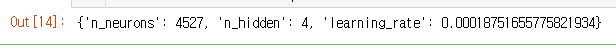

In [44]:
rnd_search_cv.best_score_

0.8228763739267985

In [45]:
rnd_search_cv.score(X_test, y_test)

63/63 [==============================] - 1s 12ms/step - loss: 158.3059 - accuracy: 0.8240


0.8240000009536743

In [46]:
model = rnd_search_cv.best_estimator_.model
model

In [47]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 1s 12ms/step - loss: 158.3059 - accuracy: 0.8240


[158.30587768554688, 0.8240000009536743]

In [48]:
model.summary()

Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_319 (Bat (None, 4096)              16384     
_________________________________________________________________
dense_447 (Dense)            (None, 4547)              18629059  
_________________________________________________________________
leaky_re_lu_319 (LeakyReLU)  (None, 4547)              0         
_________________________________________________________________
batch_normalization_320 (Bat (None, 4547)              18188     
_________________________________________________________________
dense_448 (Dense)            (None, 4547)              20679756  
_________________________________________________________________
leaky_re_lu_320 (LeakyReLU)  (None, 4547)              0         
_________________________________________________________________
batch_normalization_321 (Bat (None, 4547)           

# best param 적용

In [51]:
my_model = keras.models.Sequential()
my_model.add(keras.layers.Input(shape=[4096]))
for layer in range(4):
    my_model.add(keras.layers.BatchNormalization()) # <--- 배치 정규화
    my_model.add(keras.layers.Dense(4047, kernel_initializer="he_normal", use_bias=False, # <--- "he_normal"
                                 kernel_regularizer=keras.regularizers.l2(0.01)))
    my_model.add(keras.layers.LeakyReLU(alpha=0.2))
my_model.add(keras.layers.BatchNormalization())
my_model.add(keras.layers.Dense(3, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=0.01325711)
my_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [57]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("../my_model.h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=40)

run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join("../"+os.curdir, "my_model_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [61]:
my_history = my_model.fit(X_train, y_train, epochs=500, batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb])

Epoch 1/500
63/63 [==============================] - 5s 71ms/step - loss: 16.4839 - accuracy: 0.9914 - val_loss: 16.6152 - val_accuracy: 0.8620
Epoch 2/500
63/63 [==============================] - 3s 48ms/step - loss: 15.9240 - accuracy: 0.9989 - val_loss: 16.0824 - val_accuracy: 0.8635
Epoch 3/500
63/63 [==============================] - 3s 47ms/step - loss: 15.3970 - accuracy: 1.0000 - val_loss: 15.5686 - val_accuracy: 0.8645
Epoch 4/500
63/63 [==============================] - 3s 47ms/step - loss: 14.8901 - accuracy: 0.9999 - val_loss: 15.0774 - val_accuracy: 0.8655
Epoch 5/500
63/63 [==============================] - 3s 46ms/step - loss: 14.4001 - accuracy: 1.0000 - val_loss: 14.6009 - val_accuracy: 0.8655
Epoch 6/500
63/63 [==============================] - 3s 47ms/step - loss: 13.9266 - accuracy: 1.0000 - val_loss: 14.1526 - val_accuracy: 0.8640
Epoch 7/500
63/63 [==============================] - 3s 47ms/step - loss: 13.4685 - accuracy: 1.0000 - val_loss: 13.6994 - val_accuracy:

63/63 [==============================] - 3s 49ms/step - loss: 2.4794 - accuracy: 1.0000 - val_loss: 2.9291 - val_accuracy: 0.8735
Epoch 59/500
63/63 [==============================] - 3s 48ms/step - loss: 2.3978 - accuracy: 1.0000 - val_loss: 2.8750 - val_accuracy: 0.8670
Epoch 60/500
63/63 [==============================] - 3s 48ms/step - loss: 2.3191 - accuracy: 1.0000 - val_loss: 2.7855 - val_accuracy: 0.8675
Epoch 61/500
63/63 [==============================] - 3s 47ms/step - loss: 2.2430 - accuracy: 0.9999 - val_loss: 2.7146 - val_accuracy: 0.8725
Epoch 62/500
63/63 [==============================] - 3s 48ms/step - loss: 2.1694 - accuracy: 1.0000 - val_loss: 2.6432 - val_accuracy: 0.8740
Epoch 63/500
63/63 [==============================] - 3s 50ms/step - loss: 2.0978 - accuracy: 1.0000 - val_loss: 2.5731 - val_accuracy: 0.8720
Epoch 64/500
63/63 [==============================] - 3s 47ms/step - loss: 2.0289 - accuracy: 1.0000 - val_loss: 2.5085 - val_accuracy: 0.8755
Epoch 65/500

63/63 [==============================] - 3s 46ms/step - loss: 0.4485 - accuracy: 1.0000 - val_loss: 0.9621 - val_accuracy: 0.8605
Epoch 116/500
63/63 [==============================] - 3s 46ms/step - loss: 0.4333 - accuracy: 1.0000 - val_loss: 0.9541 - val_accuracy: 0.8615
Epoch 117/500
63/63 [==============================] - 3s 46ms/step - loss: 0.4189 - accuracy: 1.0000 - val_loss: 0.9485 - val_accuracy: 0.8595
Epoch 118/500
63/63 [==============================] - 3s 47ms/step - loss: 0.4053 - accuracy: 1.0000 - val_loss: 0.9397 - val_accuracy: 0.8600
Epoch 119/500
63/63 [==============================] - 3s 47ms/step - loss: 0.8052 - accuracy: 0.9060 - val_loss: 1.2670 - val_accuracy: 0.7770
Epoch 120/500
63/63 [==============================] - 3s 50ms/step - loss: 0.4502 - accuracy: 0.9824 - val_loss: 1.0089 - val_accuracy: 0.8290
Epoch 121/500
63/63 [==============================] - 3s 50ms/step - loss: 0.3957 - accuracy: 0.9981 - val_loss: 1.0292 - val_accuracy: 0.8360
Epoch 

Epoch 172/500
63/63 [==============================] - 3s 47ms/step - loss: 0.1601 - accuracy: 0.9962 - val_loss: 0.9150 - val_accuracy: 0.8140
Epoch 173/500
63/63 [==============================] - 3s 48ms/step - loss: 0.1507 - accuracy: 0.9970 - val_loss: 0.6761 - val_accuracy: 0.8530
Epoch 174/500
63/63 [==============================] - 3s 52ms/step - loss: 0.1382 - accuracy: 0.9998 - val_loss: 1.1485 - val_accuracy: 0.7895
Epoch 175/500
63/63 [==============================] - 3s 50ms/step - loss: 0.3146 - accuracy: 0.9523 - val_loss: 0.7433 - val_accuracy: 0.8300
Epoch 176/500
63/63 [==============================] - 3s 52ms/step - loss: 0.1501 - accuracy: 0.9964 - val_loss: 1.0461 - val_accuracy: 0.8060
Epoch 177/500
63/63 [==============================] - 3s 48ms/step - loss: 0.1400 - accuracy: 0.9981 - val_loss: 0.6967 - val_accuracy: 0.8505
Epoch 178/500
63/63 [==============================] - 3s 48ms/step - loss: 0.1315 - accuracy: 0.9996 - val_loss: 0.8018 - val_accuracy:

Epoch 229/500
63/63 [==============================] - 3s 48ms/step - loss: 0.0936 - accuracy: 1.0000 - val_loss: 0.5986 - val_accuracy: 0.8675
Epoch 230/500
63/63 [==============================] - 3s 49ms/step - loss: 0.0898 - accuracy: 1.0000 - val_loss: 0.6338 - val_accuracy: 0.8645
Epoch 231/500
63/63 [==============================] - 3s 47ms/step - loss: 0.0914 - accuracy: 0.9987 - val_loss: 0.7945 - val_accuracy: 0.8300
Epoch 232/500
63/63 [==============================] - 3s 47ms/step - loss: 0.2955 - accuracy: 0.9430 - val_loss: 0.8565 - val_accuracy: 0.8110
Epoch 233/500
63/63 [==============================] - 3s 47ms/step - loss: 0.1153 - accuracy: 0.9944 - val_loss: 0.6878 - val_accuracy: 0.8520
Epoch 234/500
63/63 [==============================] - 3s 47ms/step - loss: 0.1013 - accuracy: 0.9979 - val_loss: 0.6248 - val_accuracy: 0.8565
Epoch 235/500
63/63 [==============================] - 3s 49ms/step - loss: 0.0906 - accuracy: 0.9998 - val_loss: 0.5976 - val_accuracy:

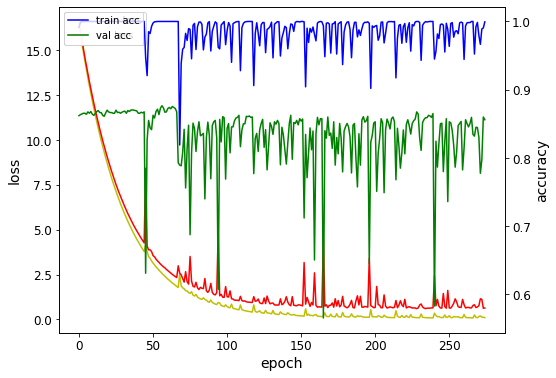

In [89]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(8, 6))
acc_ax = loss_ax.twinx()

loss_ax.plot(my_history.history['loss'], 'y', label='train loss')
loss_ax.plot(my_history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(my_history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(my_history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [76]:
%load_ext tensorboard
%tensorboard --logdir=../my_model_logs --port=6005

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6005 (pid 22440), started 0:00:15 ago. (Use '!kill 22440' to kill it.)

In [78]:
best_model = keras.models.load_model("../my_model.h5")
best_model

In [79]:
best_model.evaluate(X_test, y_test)

63/63 [==============================] - 1s 9ms/step - loss: 0.6900 - accuracy: 0.8525


[0.6899865865707397, 0.8525000214576721]

In [80]:
best_model.summary()

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_324 (Bat (None, 4096)              16384     
_________________________________________________________________
dense_452 (Dense)            (None, 4047)              16576512  
_________________________________________________________________
leaky_re_lu_323 (LeakyReLU)  (None, 4047)              0         
_________________________________________________________________
batch_normalization_325 (Bat (None, 4047)              16188     
_________________________________________________________________
dense_453 (Dense)            (None, 4047)              16378209  
_________________________________________________________________
leaky_re_lu_324 (LeakyReLU)  (None, 4047)              0         
_________________________________________________________________
batch_normalization_326 (Bat (None, 4047)           

In [123]:
my_model = keras.models.Sequential()
my_model.add(keras.layers.Input(shape=[4096]))
for layer in range(4):
    my_model.add(keras.layers.BatchNormalization()) # <--- 배치 정규화
    my_model.add(keras.layers.Dense(4048, kernel_initializer="he_normal", use_bias=False, # <--- "he_normal"
                                 kernel_regularizer=keras.regularizers.l2(0.0015)))
    my_model.add(keras.layers.LeakyReLU(alpha=0.2))
my_model.add(keras.layers.BatchNormalization())
my_model.add(keras.layers.Dense(3, activation="softmax"))

#optimizer = keras.optimizers.SGD(lr=0.01325711)
optimizer = keras.optimizers.SGD(lr=0.0525711)
my_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [124]:
run_index += 1 # 모델을 훈련할 때마다 증가시킴

checkpoint_cb = keras.callbacks.ModelCheckpoint("../my_model"+str(run_index)+".h5", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=40)
run_logdir = os.path.join("../"+os.curdir, "my_model_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
print(f'run_index: {run_index}')

run_index: 12


In [125]:
my_history = my_model.fit(X_train, y_train, epochs=500, batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, tensorboard_cb, early_stopping_cb])

Epoch 1/500
125/125 [==============================] - 7s 48ms/step - loss: 51.0445 - accuracy: 0.5800 - val_loss: 48.7039 - val_accuracy: 0.6295
Epoch 2/500
125/125 [==============================] - 5s 40ms/step - loss: 47.1984 - accuracy: 0.7764 - val_loss: 45.8734 - val_accuracy: 0.7735
Epoch 3/500
125/125 [==============================] - 5s 40ms/step - loss: 45.2030 - accuracy: 0.8183 - val_loss: 44.1387 - val_accuracy: 0.7890
Epoch 4/500
125/125 [==============================] - 5s 40ms/step - loss: 43.2895 - accuracy: 0.8713 - val_loss: 42.7551 - val_accuracy: 0.7785
Epoch 5/500
125/125 [==============================] - 5s 40ms/step - loss: 41.6450 - accuracy: 0.8865 - val_loss: 40.8586 - val_accuracy: 0.7870
Epoch 6/500
125/125 [==============================] - 5s 40ms/step - loss: 39.9034 - accuracy: 0.9214 - val_loss: 39.1961 - val_accuracy: 0.8230
Epoch 7/500
125/125 [==============================] - 5s 40ms/step - loss: 38.3460 - accuracy: 0.9318 - val_loss: 37.9110 -

Epoch 57/500
125/125 [==============================] - 5s 42ms/step - loss: 5.8121 - accuracy: 0.9442 - val_loss: 6.3567 - val_accuracy: 0.8305
Epoch 58/500
125/125 [==============================] - 5s 40ms/step - loss: 5.4325 - accuracy: 0.9808 - val_loss: 6.0250 - val_accuracy: 0.8485
Epoch 59/500
  1/125 [..............................] - ETA: 4s - loss: 5.2553 - accuracy: 0.9844

KeyboardInterrupt: 

In [ ]:
# 4번 0.85

In [ ]:
#10번  lr=0.0525711 l2(0.002) b_size = 128 0.8575